Required libraries

In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg
!pip install pydicom
!pip install pydicom matplotlib pandas tensorflow scikit-learn
!pip install pydicom SimpleITK matplotlib kaggle
!pip install tensorflow-addons
!pip install tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
# Set up Kaggle authentication
from google.colab import files
files.upload()  # Upload kaggle.json file

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Download the RSNA dataset
!kaggle competitions download -c rsna-2024-lumbar-spine-degenerative-classification
!unzip -q rsna-2024-lumbar-spine-degenerative-classification.zip

100% 28.2G/28.2G [20:47<00:00, 32.2MB/s]
100% 28.2G/28.2G [20:47<00:00, 24.3MB/s]


Modelling

In [ ]:
import os
import numpy as np
import pandas as pd
import pydicom
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Load the CSV files
train_series_descriptions_path = '/content/train_series_descriptions.csv'
train_label_coordinates_path = '/content/train_label_coordinates.csv'
train_path = '/content/train.csv'

df_train_series_descriptions = pd.read_csv(train_series_descriptions_path)
df_train_label_coordinates = pd.read_csv(train_label_coordinates_path)
df_train = pd.read_csv(train_path)

# Function to search for DICOM files in two-level nested subdirectories
def find_dicom_files(base_dir):
    dicom_files = {}
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".dcm"):
                # Extract study_id from the first subfolder (e.g., train_images/100206310/1012284084/1.dcm)
                subdirs = root.split(os.sep)
                if len(subdirs) >= 2:
                    study_id = subdirs[-2]  # Get the second-to-last folder as the study_id
                    dicom_files[study_id] = os.path.join(root, file)
    return dicom_files

# Set the base path for train images
train_images_base_path = '/content/train_images/'

# Get a dictionary mapping study_id to file paths
dicom_file_map = find_dicom_files(train_images_base_path)

# Check how many DICOM files were found
print(f"Number of DICOM files found: {len(dicom_file_map)}")

# Print a few entries in the map to verify
for study_id, file_path in list(dicom_file_map.items())[:5]:
    print(f"Study ID: {study_id}, File Path: {file_path}")

# Filter for Sagittal T1 images from `train_series_descriptions.csv`
sagittal_t1_series = df_train_series_descriptions[df_train_series_descriptions['series_description'].str.contains("Sagittal T1", case=False)]
sagittal_t1_ids = sagittal_t1_series['study_id'].values

# Merge `train_label_coordinates` with `train.csv` to get conditions and labels
df_combined = pd.merge(df_train_label_coordinates, df_train, on='study_id')

# Filter the combined DataFrame for only Sagittal T1 study_ids
df_sagittal_combined = df_combined[df_combined['study_id'].isin(sagittal_t1_ids)]

# Function to preprocess DICOM images
def preprocess_dicom_image(dicom_path):
    try:
        dicom = pydicom.dcmread(dicom_path)
        image = dicom.pixel_array

        # Normalize the image to 8-bit if it's not already in the correct format
        if image.dtype != np.uint8:
            image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)

        # Resize the image to the model input size (299x299 for ResNet/InceptionV3)
        image_resized = cv2.resize(image, (299, 299))

        # Convert grayscale image to RGB (for models like ResNet50)
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)

        return image_rgb
    except Exception as e:
        print(f"Error processing {dicom_path}: {e}")
        return None

# Preprocess and store images
processed_images = []
for study_id in df_sagittal_combined['study_id'].unique():
    dicom_path = dicom_file_map.get(str(study_id))  # Convert study_id to string, if needed

    if dicom_path is None:
        print(f"No DICOM file found for study ID: {study_id}")
        continue

    processed_image = preprocess_dicom_image(dicom_path)

    if processed_image is not None:
        processed_images.append(processed_image)

# Check if there are any processed images
print(f"Number of processed images: {len(processed_images)}")

# If there are no images, stop execution
if len(processed_images) == 0:
    print("No images were processed. Please check the file paths and data.")
else:
    # Convert processed images to numpy array for training
    X_train = np.array(processed_images)

    # Encoding labels (we'll use the condition or severity level as labels)
    encoder = LabelEncoder()

    # Example: Using 'condition' column from the merged dataset
    y_train = encoder.fit_transform(df_sagittal_combined['condition'])  # Assuming 'condition' is the target
    y_train = to_categorical(y_train, num_classes=len(encoder.classes_))

    # Model setup (ResNet50-based)
    model = Sequential([
        ResNet50(input_shape=(299, 299, 3), include_top=False, weights='imagenet', pooling='avg'),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(encoder.classes_), activation='softmax')  # Output layer for classification
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)


Number of DICOM files found: 1975
Study ID: 1827626416, File Path: /content/train_images/1827626416/3700096577/22.dcm
Study ID: 4071042236, File Path: /content/train_images/4071042236/2833232079/7.dcm
Study ID: 4057365107, File Path: /content/train_images/4057365107/1903217931/7.dcm
Study ID: 3448721674, File Path: /content/train_images/3448721674/2636050995/34.dcm
Study ID: 3945605592, File Path: /content/train_images/3945605592/3974032618/22.dcm
Number of processed images: 1972
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.2131 - loss: 1.8267 - val_accuracy: 0.1797 - val_loss: 1.6765


Evaluating the model ResNet50

In [ ]:
# Preprocess test images in the same way as the training images
test_images_base_path = '/content/test_images/'
dicom_test_file_map = find_dicom_files(test_images_base_path)

# Load the test series descriptions file
test_series_descriptions_path = '/content/test_series_descriptions.csv'
df_test_series_descriptions = pd.read_csv(test_series_descriptions_path)

# Filter for Sagittal T1 images in the test set
sagittal_t1_test_series = df_test_series_descriptions[df_test_series_descriptions['series_description'].str.contains("Sagittal T1", case=False)]
test_study_ids = sagittal_t1_test_series['study_id'].values  # Extract test study_ids for Sagittal T1 images

# Check the number of test study_ids
print(f"Number of test study_ids: {len(test_study_ids)}")


# Preprocess and store test images
processed_test_images = []
for study_id in test_study_ids:  # Assuming you have a list of study_ids for test images
    dicom_path = dicom_test_file_map.get(str(study_id))
    if dicom_path is None:
        print(f"No DICOM file found for test Study ID: {study_id}")
        continue
    processed_image = preprocess_dicom_image(dicom_path)
    if processed_image is not None:
        processed_test_images.append(processed_image)

X_test = np.array(processed_test_images)

# Make predictions on the test set
predictions = model.predict(X_test)


Number of test study_ids: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Convert the predictions to class indices
y_pred = np.argmax(predictions, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


In [ ]:
# Assuming y_pred contains predicted class indices
y_pred = np.argmax(predictions, axis=1)

# Save predictions in the required format for submission (if for Kaggle)
submission = pd.DataFrame({
    'Study_ID': test_study_ids,  # Replace with actual test study IDs
    'Predicted_Label': y_pred  # Predicted labels
})

submission.to_csv('submission.csv', index=False)


Visualizations

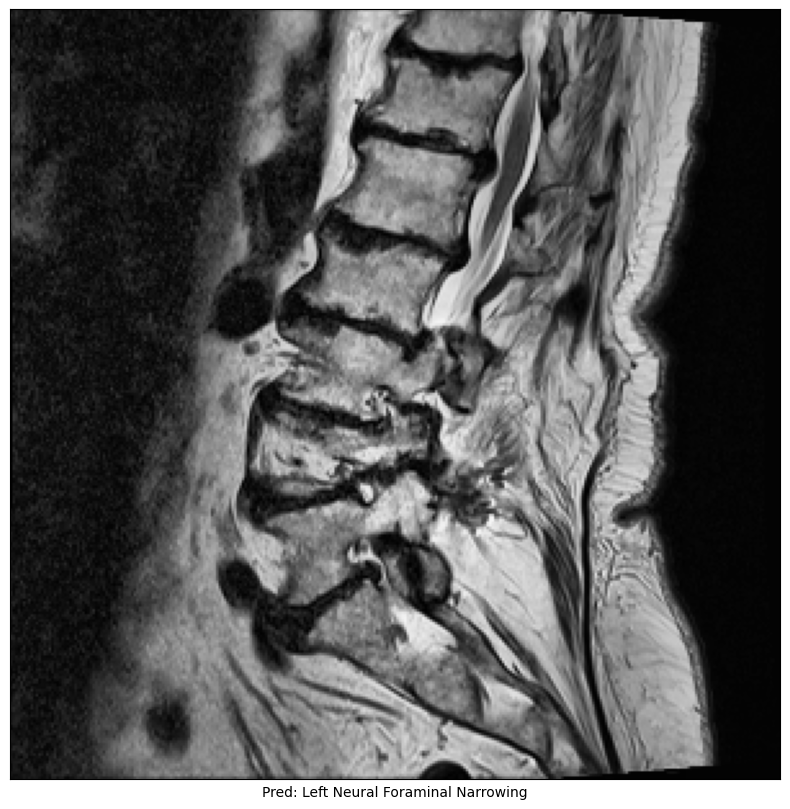

In [ ]:
import matplotlib.pyplot as plt
# Function to display images with predicted labels (since true labels are not available)
def plot_predictions_without_true_labels(images, predicted_labels, class_names, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)

        # Show predicted label
        predicted_label = class_names[predicted_labels[i]]
        plt.xlabel(f"Pred: {predicted_label}")
    plt.show()

# Assuming `X_test` and `predictions` are available
y_pred = np.argmax(predictions, axis=1)  # Convert predictions to class indices
class_names = encoder.classes_  # Class names

# Check the number of images in X_test
num_images = min(5, X_test.shape[0])  # Set the number of images to the minimum of 5 or the size of X_test

# Visualize predictions without true labels
plot_predictions_without_true_labels(X_test, y_pred, class_names, num_images=num_images)



CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# InceptionV3 model
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = inception_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(encoder.classes_), activation='softmax')(x)

inception_model = Model(inputs=inception_base.input, outputs=predictions)

# Freeze InceptionV3 layers
for layer in inception_base.layers:
    layer.trainable = False

inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
inception_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 149, 149, 32)   │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 149, 149, 32)   │             96 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 149, 149, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 147, 147, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 147, 147, 32)   │             96 │ conv2d_98[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 147, 147, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_99 (Conv2D)        │ (None, 147, 147, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 147, 147, 64)   │            192 │ conv2d_99[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 147, 147, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 73, 73, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 73, 73, 80)     │            240 │ conv2d_100[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 73, 73, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)  

 Total params: 22,065,701 (84.17 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

VGG

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = vgg16_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(encoder.classes_), activation='softmax')(x)

vgg16_model = Model(inputs=vgg16_base.input, outputs=predictions)

# Freeze VGG16 layers
for layer in vgg16_base.layers:
    layer.trainable = False

vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 299, 299, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 299, 299, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 149, 149, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 149, 149, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 149, 149, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 74, 74, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 74, 74, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 74, 74, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 74, 74, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 37, 37, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 37, 37, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 18, 18, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 14,780,997 (56.39 MB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

EfficientNetV2

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0

# EfficientNetV2 model
efficientnet_base = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = efficientnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(encoder.classes_), activation='softmax')(x)

efficientnet_model = Model(inputs=efficientnet_base.input, outputs=predictions)

# Freeze EfficientNetV2 layers
for layer in efficientnet_base.layers:
    layer.trainable = False

efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
efficientnet_model.summary()


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 299, 299, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 299, 299, 3)    │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 32)   │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 150, 150, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 150, 150, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 150, 150, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, 75, 75, 64)     │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, 75, 75, 64)     │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, 75, 75, 64)     │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, 75, 75, 32)     │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, 75, 75, 32)     │            128 │ block2a_project_conv[… │
│ (BatchNormalization) 

 Total params: 6,083,925 (23.21 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

Integration of models

In [ ]:
# Train the InceptionV3 model
inception_model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)

# Train the VGG16 model
vgg16_model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)

# Train the EfficientNetV2 model
efficientnet_model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)


50/50 ━━━━━━━━━━━━━━━━━━━━ 484s 10s/step - accuracy: 0.1940 - loss: 6.2777 - val_accuracy: 0.1848 - val_loss: 3.3249
50/50 ━━━━━━━━━━━━━━━━━━━━ 1874s 38s/step - accuracy: 0.1952 - loss: 2.7562 - val_accuracy: 0.2253 - val_loss: 1.9270
50/50 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.1845 - loss: 1.7038 - val_accuracy: 0.1772 - val_loss: 1.6389


Visualizations of prediction

In [ ]:
print(f"Shape of X_test: {X_test.shape}")


Shape of X_test: (1, 299, 299, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


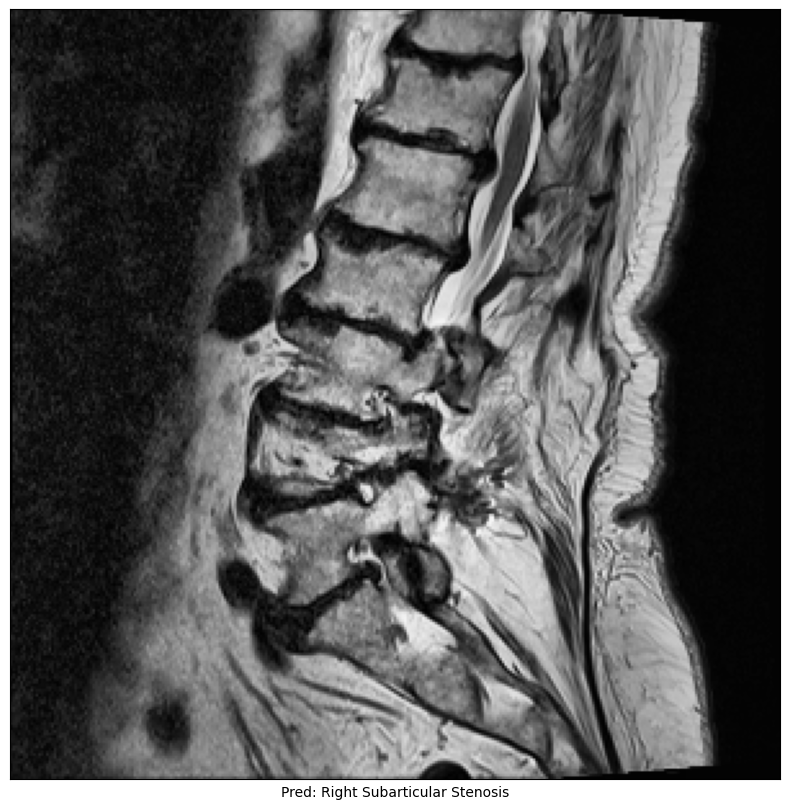

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


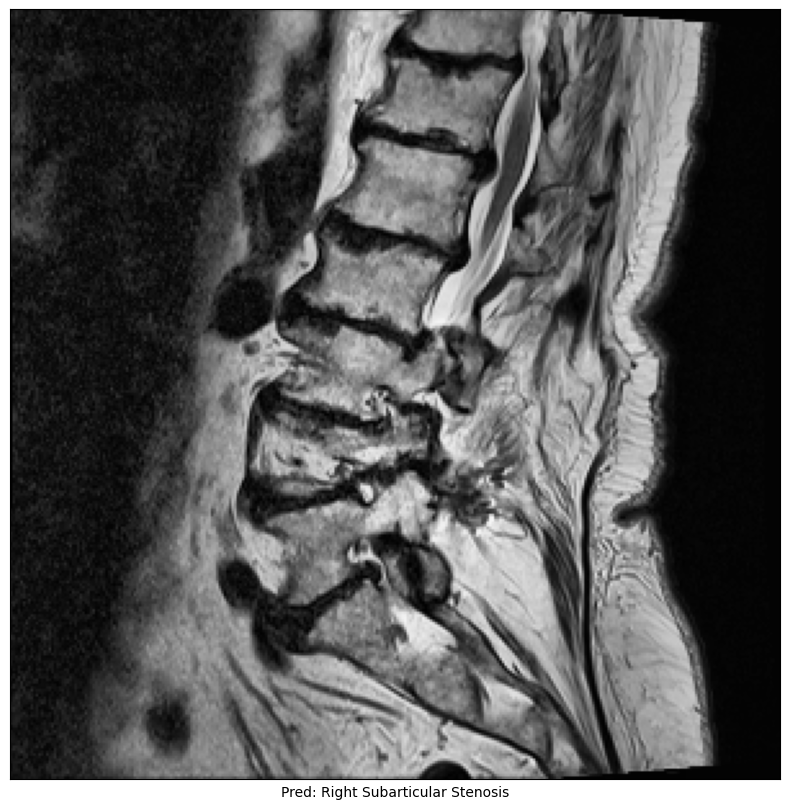

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


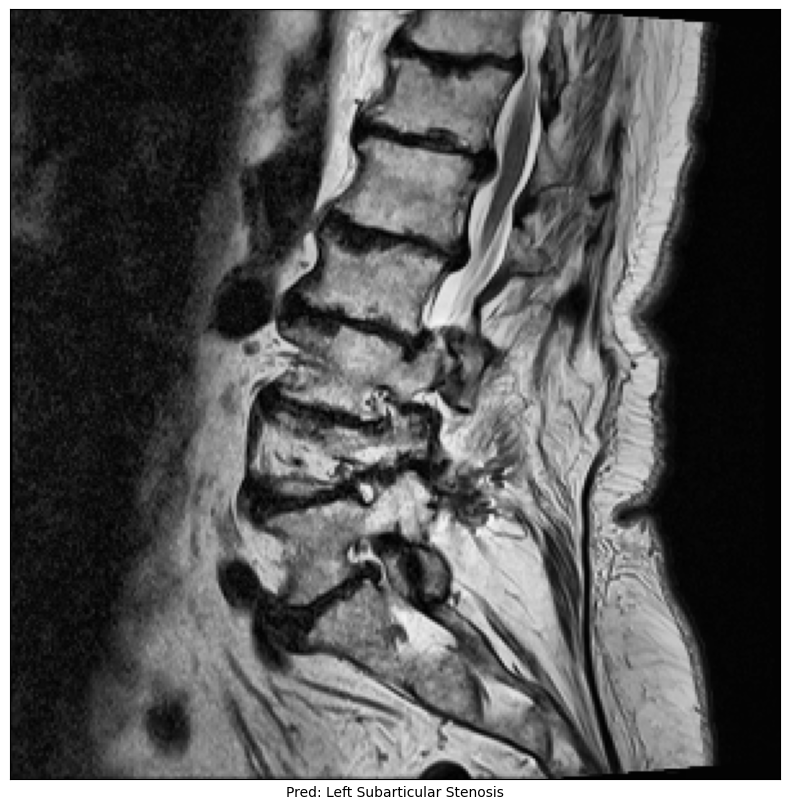

In [ ]:
import matplotlib.pyplot as plt

# Function to display images with predicted labels (since true labels are not available)
def plot_predictions(images, predicted_labels, class_names, num_images=5):
    # Make sure we don't try to plot more images than we have
    num_images = min(num_images, len(images))

    if num_images == 0:
        print("No images to display.")
        return

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)

        # Show predicted label
        predicted_label = class_names[predicted_labels[i]]
        plt.xlabel(f"Pred: {predicted_label}")
    plt.show()

# Usage for any model (e.g., InceptionV3, VGG16, etc.)
def visualize_predictions(model, X_test, class_names, num_images=5):
    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Convert predictions to class indices
    predicted_labels = np.argmax(predictions, axis=1)

    # Plot the predictions
    plot_predictions(X_test, predicted_labels, class_names, num_images)

# Class names (from your label encoder)
class_names = encoder.classes_

# Visualize predictions for each model
#visualize_predictions(resnet_model, X_test, class_names)
visualize_predictions(inception_model, X_test, class_names)
visualize_predictions(vgg16_model, X_test, class_names)
visualize_predictions(efficientnet_model, X_test, class_names)


Trying to use the meta data now

In [ ]:
import pandas as pd

In [ ]:
import pydicom

# Load a sample DICOM file to inspect available metadata
dicom_file = '/content/train_images/100206310/1012284084/1.dcm'
dicom = pydicom.dcmread(dicom_file)

# Print all available metadata fields
print(dicom)


Dataset.file_meta -------------------------------
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 100206310.1.1
(0002,0010) Transfer Syntax UID                 UI: RLE Lossless
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008,0018) SOP Instance UID                    UI: 100206310.1.1
(0008,0023) Content Date                        DA: '20240503'
(0008,0033) Content Time                        TM: '223743.757829'
(0008,103E) Series Description                  LO: 'T2'
(0010,0020) Patient ID                          LO: '100206310'
(0018,0050) Slice Thickness                     DS: '3.5'
(0018,0088) Spacing Between Slices              DS: '3.5'
(0018,5100) Patient Position                    CS: 'HF

In [ ]:
import pandas as pd
import pydicom

# Function to extract metadata from DICOM files, including additional fields
def extract_metadata(dicom_path):
    try:
        dicom = pydicom.dcmread(dicom_path)
        metadata = {
            'PatientAge': float(dicom.PatientAge[:-1]) if 'PatientAge' in dicom else None,
            'PatientSex': dicom.PatientSex if 'PatientSex' in dicom else None,
            'SliceThickness': float(dicom.SliceThickness) if 'SliceThickness' in dicom else None,
            'SpacingBetweenSlices': float(dicom.SpacingBetweenSlices) if 'SpacingBetweenSlices' in dicom else None,
            'PatientPosition': dicom.PatientPosition if 'PatientPosition' in dicom else None,
            'SeriesDescription': dicom.SeriesDescription if 'SeriesDescription' in dicom else None,
            'ImageOrientationPatient': dicom.ImageOrientationPatient if 'ImageOrientationPatient' in dicom else None,
            'ImagePositionPatient': dicom.ImagePositionPatient if 'ImagePositionPatient' in dicom else None,
            'SliceLocation': float(dicom.SliceLocation) if 'SliceLocation' in dicom else None,
            'PixelSpacing': dicom.PixelSpacing[0] if 'PixelSpacing' in dicom and isinstance(dicom.PixelSpacing, list) else None,
            'WindowCenter': float(dicom.WindowCenter) if 'WindowCenter' in dicom else None,
            'WindowWidth': float(dicom.WindowWidth) if 'WindowWidth' in dicom else None,
        }
        return metadata
    except Exception as e:
        print(f"Error extracting metadata from {dicom_path}: {e}")
        return None

# Assume `dicom_paths` is a list of DICOM file paths
dicom_paths = ['/path/to/dicom1.dcm', '/path/to/dicom2.dcm']  # Add your actual DICOM file paths here

# Extract metadata for each DICOM file
metadata_list = [extract_metadata(dicom_path) for dicom_path in dicom_paths]

# Create a DataFrame from the metadata
df_metadata = pd.DataFrame(metadata_list)

# Handle categorical fields (PatientPosition, SeriesDescription) using one-hot encoding
df_metadata = pd.get_dummies(df_metadata, columns=['PatientPosition', 'SeriesDescription'])

# Handle missing values and ensure numeric types
df_metadata.fillna(0, inplace=True)  # Fill missing values with 0
metadata_features = df_metadata.astype(np.float32).values  # Convert all features to float32 for TensorFlow


Error extracting metadata from /path/to/dicom1.dcm: [Errno 2] No such file or directory: '/path/to/dicom1.dcm'
Error extracting metadata from /path/to/dicom2.dcm: [Errno 2] No such file or directory: '/path/to/dicom2.dcm'


KeyError: "None of [Index(['PatientPosition', 'SeriesDescription'], dtype='object')] are in the [columns]"

Normalizing data

In [ ]:
from sklearn.preprocessing import StandardScaler

# Example of normalization (assuming 'PatientAge' and 'SliceThickness' are numerical fields)
scaler = StandardScaler()
df_metadata[['PatientAge', 'SliceThickness']] = scaler.fit_transform(df_metadata[['PatientAge', 'SliceThickness']])

# One-hot encode categorical fields (e.g., 'PatientSex')
df_metadata = pd.get_dummies(df_metadata, columns=['PatientSex'])

# Merge the metadata with the main dataset on 'study_id'
df_combined_with_metadata = pd.merge(df_sagittal_combined, df_metadata, on='study_id')


Multi input model

In [ ]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

# Image branch (using ResNet50 for image processing)
image_input = Input(shape=(299, 299, 3))
image_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')(image_input)
image_dense = Dense(128, activation='relu')(image_model)

# Metadata branch (for structured metadata input)
metadata_input = Input(shape=(df_metadata.shape[1] - 1,))  # Exclude 'study_id' column
metadata_dense = Dense(64, activation='relu')(metadata_input)

# Combine both branches
combined = Concatenate()([image_dense, metadata_dense])

# Add output layer
output = Dense(len(encoder.classes_), activation='softmax')(combined)

# Build and compile the model
multi_input_model = Model(inputs=[image_input, metadata_input], outputs=output)
multi_input_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Convert image data to float32
X_train = X_train.astype(np.float32)

# Convert metadata features to float32 and handle missing values
metadata_features = df_metadata.drop(columns=['study_id']).fillna(0).values
metadata_features = metadata_features.astype(np.float32)

# Ensure the labels are in the correct format (one-hot encoded)
y_train = y_train.astype(np.float32)

# Check the shapes of the inputs and outputs
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of metadata_features: {metadata_features.shape}")
print(f"Shape of y_train: {y_train.shape}")

# Train the multi-input model
multi_input_model.fit([X_train, metadata_features], y_train, epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
from sklearn.metrics import f1_score

# Make predictions on the validation set
y_val_pred = multi_input_model.predict([X_val, val_metadata_features])

# Convert predictions to class indices
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)  # Assuming y_val contains true labels for validation

# Calculate F1-score
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print(f'F1 Score on validation set: {f1:.4f}')
